In [1]:
import argparse
import self_distillation
import distillation
import saving_loading
import generate
import wandb
import util
import os
import os
import sys
import torch
import importlib
import tqdm
import numpy as np
from omegaconf import OmegaConf
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
from ldm.models.diffusion.ddim import DDIMSampler
from IPython.display import display, clear_output
from ldm.models.diffusion.plms import PLMSSampler
from ldm.util import *
import torch.nn as nn
import copy
import wandb
import math
import traceback
from pytorch_fid import fid_score
import shutil
import util
import saving_loading
import generate

gradient_updates = 4000
lr = 0.0001
steps = 8
step_scheduler = "naive"
x0 = True
warmup_epochs = 1000
cwd = os.getcwd()

model_path=f"{cwd}/models/cin256_retrained.pt"
config_path = f"{cwd}/models/configs/cin256-v2-custom_x0.yaml"

student, sampler_student = util.create_models(config_path, model_path, student=False)
original, sampler_original = util.create_models(config_path, model_path, student=False)
optimizer, scheduler = util.get_optimizer(sampler_student, iterations=gradient_updates, warmup_epochs=warmup_epochs,lr=lr)

Loading model from c:\Code\Thesis\DSD/models/cin256_retrained.pt


c:\Users\Paper\miniconda3\envs\D-SD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in x0-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 16, 16) = 768 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading model from c:\Code\Thesis\DSD/models/cin256_retrained.pt
LatentDiffusion: Running in x0-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 16, 16) = 768 dimensions.
making attention of type 'vanilla' with 512 in_channels


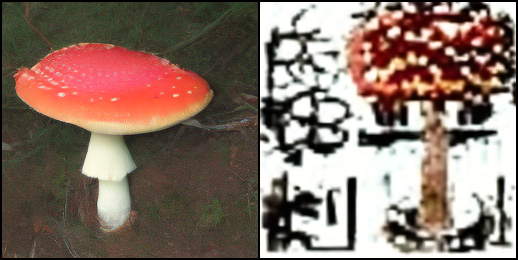

  1%|▏         | 14/1000 [01:12<1:25:03,  5.18s/it]


KeyboardInterrupt: 

In [3]:
NUM_CLASSES = 1000
ddim_steps_student = steps # Setting the number of steps for the student model
ddim_eta = 0.0 # Setting the eta value to 0.0 means a deterministic output given the original noise, essential
# For both the student and the original model, the number of steps is set to the same value. 
# Technically the original model does not need to be trained, but it is kept for comparison purposes.
sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
sampler_original.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
ddim_eta = 0.0 # Setting the eta value to 0.0 means a deterministic output given the original noise, essential
scale = 3.0 # This is $w$ in the paper, the CFG scale. Can be left static or varied as is done occasionally.
criterion = nn.MSELoss() 

instance = 0 # Actual instance of student gradient updates
generation = 0 # The amount of final-step images generated
averaged_losses = []
all_losses = []

if step_scheduler == "iterative": # Halve the number of steps from start to 1 with even allocation of gradient updates
    halvings = math.floor(math.log(ddim_steps_student)/math.log(2))
    updates_per_halving = int(gradient_updates / halvings)
    step_sizes = []
    for i in range(halvings):
        step_sizes.append(int((steps) / (2**i)))
    update_list = []
    for i in step_sizes:
        update_list.append(int(updates_per_halving / int(i/ 2))) # /2 because of 2 steps per update
elif step_scheduler == "naive": # Naive approach, evenly distribute gradient updates over all steps
    step_sizes=[ddim_steps_student]
    update_list=[gradient_updates // int(ddim_steps_student / 2)] # /2 because of 2 steps per update
elif step_scheduler == "gradual_linear": # Gradually decrease the number of steps to 1, with even allocation of gradient updates
    step_sizes = np.arange(steps, 0, -2)
    update_list = ((1/len(np.append(step_sizes[1:], 1)) * gradient_updates / np.append(step_sizes[1:], 1))).astype(int) * 2 # *2 because of 2 steps per update
elif step_scheduler == "gradual_exp": # TEMPORARY VERSION, to test if focus on higher steps is better, reverse of the one below
    step_sizes = np.arange(64, 0, -2)
    update_list = np.exp((1 / np.append(step_sizes[1:],1))[::-1]) / np.sum(np.exp((1 / np.append(step_sizes[1:],1))[::-1]))
    update_list = (update_list * gradient_updates /  np.append(step_sizes[1:],1)).astype(int) * 2 # *2 because of 2 steps per update
# elif step_scheduler == "gradual_exp": # Exponential decrease in number of gradient updates per step
#     step_sizes = np.arange(64, 0, -2)
#     update_list = np.exp(1 / np.append(step_sizes[1:],1)) / np.sum(np.exp(1 / np.append(step_sizes[1:],1)))
#     update_list = ((update_list * 2) * gradient_updates /  np.append(step_sizes[1:],1)).astype(int)

with torch.no_grad():
    # student.use_ema = True
    # with student.ema_scope(): 
            if x0:
                sc=None
            else:
                sc = student.get_learned_conditioning({student.cond_stage_key: torch.tensor(1*[1000]).to(student.device)}) # Get the learned conditioning
            for i, step in enumerate(step_sizes): # For each step size
                # if instance != 0 and "gradual" not in step_scheduler:   # Save the model after every step size. Given the large model size, 
                #                                                         # the gradual versions are not saved each time (steps * 2 * 4.7gb is a lot!)
                #     util.save_model(sampler_student, optimizer, scheduler, name=step_scheduler, steps=updates, run_name=run_name)
                updates = int(step / 2) # We take updates as half the step size, because we do 2 steps per update
                generations = update_list[i] # The number of generations has been determined earlier
                print("Distilling to:", step)
                
                with tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))) as tepoch: # Take a random class for each generation

                    for i, class_prompt in enumerate(tepoch):
                        generation += 1
                        losses = []       
                        scale = 3.0
                        #scale = np.random.uniform(1.0, 4.0) # Randomly sample a scale for each generation, optional
                        c_student = student.get_learned_conditioning({student.cond_stage_key: torch.tensor([class_prompt]).to(student.device)}) # Set to 0 for unconditional, requires pretraining
                        
                        samples_ddim= None # Setting to None will create a new noise vector for each generation
                        predictions_temp = []
                        
                        for steps in range(updates):
                            # with autocast() and torch.enable_grad(): # For mixed precision training, should not be used for final results
                                with torch.enable_grad():
                                        instance += 1
                                        
                                        optimizer.zero_grad()
                                        samples_ddim, pred_x0_student, _, at= sampler_student.sample_student(S=1,
                                                                            conditioning=c_student,
                                                                            batch_size=1,
                                                                            shape=[3, 64, 64],
                                                                            verbose=False,
                                                                            x_T=samples_ddim, # start noise or teacher output
                                                                            unconditional_guidance_scale=scale,
                                                                            unconditional_conditioning=sc, 
                                                                            eta=ddim_eta,
                                                                            keep_intermediates=False,
                                                                            intermediate_step = steps*2,
                                                                            steps_per_sampling = 1,
                                                                            total_steps = ddim_steps_student)
                                        
                                        # Code below first decodes the latent image and then reconstructs it. This is not necessary, but can be used to check if the latent image is correct
                                        # decode_student = student.differentiable_decode_first_stage(pred_x0_student)
                                        # reconstruct_student = torch.clamp((decode_student+1.0)/2.0, min=0.0, max=1.0)
                                        
                                        

                                        with torch.no_grad():
                                            samples_ddim.detach()
                                            samples_ddim, _, _, pred_x0_teacher, _ = sampler_student.sample(S=1,
                                                                        conditioning=c_student,
                                                                        batch_size=1,
                                                                        shape=[3, 64, 64],
                                                                        verbose=False,
                                                                        x_T=samples_ddim, # output of student
                                                                        unconditional_guidance_scale=scale,
                                                                        unconditional_conditioning=sc, 
                                                                        eta=ddim_eta,
                                                                        keep_intermediates=False,
                                                                        intermediate_step = steps*2+1,
                                                                        steps_per_sampling = 1,
                                                                        total_steps = ddim_steps_student)     

                                            # decode_teacher = student.decode_first_stage(pred_x0_teacher)
                                            # reconstruct_teacher = torch.clamp((decode_teacher+1.0)/2.0, min=0.0, max=1.0)
                                        signal = at
                                        noise = 1 - at
                                        log_snr = torch.log(signal / noise)
                                        weight = max(log_snr, 1)
                                        loss = weight *  criterion(pred_x0_student, pred_x0_teacher.detach())     
                                        # loss = weight * criterion(reconstruct_student, reconstruct_teacher.detach())                    
                                        loss.backward()
                                        optimizer.step()
                                        scheduler.step()
                                        # torch.nn.utils.clip_grad_norm_(sampler_student.model.parameters(), 1)
                                        losses.append(loss.item())

                                        
                        if  generation > 0 and generation % 2 == 0: # or instance==1:

                                with torch.no_grad():
                                    # the x0 version keeps max denoising steps to 64
                                    images, _ = util.compare_teacher_student_x0(original, sampler_original, student, sampler_student, steps=[8], prompt=992, x0=x0)
                                    # images = wandb.Image(_, caption="left: Teacher, right: Student")
                                    # wandb.log({"pred_x0": images})
                                    clear_output(wait=True)
                                    display(images)
                                    # # Optional; compare the images but also change the denoising schedule
                                    # images, _ = util.compare_teacher_student(original, sampler_original, student, sampler_student, steps=[64, 16, 8,  4, 2, 1], prompt=992,x0=x0)
                                    # # images = wandb.Image(_, caption="left: Teacher, right: Student")
                                    # # wandb.log({"with_sched": images})

                                    # Important: Reset the schedule, as compare_teacher_student changes max steps. 
                                    sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                                    sampler_original.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
